In [12]:

import os, json
import cv2
import numpy as np

OUTPUT_ROOT = "/content/output_dataset"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

print("OpenCV:", cv2.__version__)
print("Output root:", OUTPUT_ROOT)


OpenCV: 4.13.0
Output root: /content/output_dataset


In [13]:

ORIGINAL_PATH = "/content/157_00150.png"
SEM_ID_PATH   = "/content/157_00150_semantic_id_with_guitar.png"

print("Exists original:", os.path.exists(ORIGINAL_PATH), ORIGINAL_PATH)
print("Exists sem_id: ", os.path.exists(SEM_ID_PATH), SEM_ID_PATH)


Exists original: True /content/157_00150.png
Exists sem_id:  True /content/157_00150_semantic_id_with_guitar.png


In [14]:
#Load images ---
original = cv2.imread(ORIGINAL_PATH, cv2.IMREAD_COLOR)
sem_id   = cv2.imread(SEM_ID_PATH,  cv2.IMREAD_UNCHANGED)

if original is None:
    raise ValueError(f"Couldn't read ORIGINAL_PATH: {ORIGINAL_PATH}")
if sem_id is None:
    raise ValueError(f"Couldn't read SEM_ID_PATH: {SEM_ID_PATH}")

if sem_id.ndim == 3:
    sem_id = sem_id[:, :, 0]

if original.shape[:2] != sem_id.shape[:2]:
    sem_id = cv2.resize(sem_id, (original.shape[1], original.shape[0]), interpolation=cv2.INTER_NEAREST)

print("original:", original.shape, original.dtype)
print("sem_id:  ", sem_id.shape, sem_id.dtype)
uniq = np.unique(sem_id)
print("Unique class IDs:", len(uniq))
print("First 30 IDs:", uniq[:30])


original: (960, 540, 3) uint8
sem_id:   (960, 540) uint8
Unique class IDs: 7
First 30 IDs: [ 1  2  3  4  8 12 13]


In [15]:
label2id = None
id2label = None
TARGET_LABELS = []

In [16]:

MANUAL_CLASS_IDS = {
    "person": 1,
    "object": 13,
}

def resolve_targets():
    targets = {}
    if label2id is not None:
        for lab in TARGET_LABELS:
            key = lab.lower().strip()
            if key not in label2id:
                print(f"WARNING: label '{lab}' not found in id2label. You may need MANUAL_CLASS_IDS instead.")
                continue
            targets[lab] = int(label2id[key])

    for name, cid in MANUAL_CLASS_IDS.items():
        targets[name] = int(cid)

    if not targets:
        raise ValueError("No targets resolved. Provide id2label.json + TARGET_LABELS, or set MANUAL_CLASS_IDS.")

    return targets

targets = resolve_targets()
print("Targets:")
for name, cid in targets.items():
    print(f" - {name}: id={cid} ({id2label.get(cid) if id2label else 'no mapping'})")


Targets:
 - person: id=1 (no mapping)
 - object: id=13 (no mapping)


In [17]:
#Instance extraction utilities ---
def clean_binary(binary, k=5, open_it=1, close_it=2):
    kernel = np.ones((k, k), np.uint8)
    if open_it > 0:
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=open_it)
    if close_it > 0:
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=close_it)
    return binary

def extract_instances_from_semid(
    original_bgr,
    sem_id,
    class_id,
    out_dir,
    class_name,
    min_area=1200,
    pad=0
):
    os.makedirs(out_dir, exist_ok=True)

    binary = (sem_id == class_id).astype(np.uint8) * 255
    binary = clean_binary(binary, k=5, open_it=1, close_it=2)

    cv2.imwrite(f"/content/debug_{class_name}_mask.png", binary)

    n, labels = cv2.connectedComponents(binary)
    count = 0

    for lab in range(1, n):
        inst = (labels == lab).astype(np.uint8) * 255
        area = cv2.countNonZero(inst)
        if area < min_area:
            continue

        x, y, w, h = cv2.boundingRect(inst)

        x0 = max(0, x - pad); y0 = max(0, y - pad)
        x1 = min(original_bgr.shape[1], x + w + pad)
        y1 = min(original_bgr.shape[0], y + h + pad)

        crop_rgb  = original_bgr[y0:y1, x0:x1]
        crop_mask = inst[y0:y1, x0:x1]

        bgra = cv2.cvtColor(crop_rgb, cv2.COLOR_BGR2BGRA)
        bgra[:, :, 3] = crop_mask

        out_path = os.path.join(out_dir, f"{class_name}_{count:03d}.png")
        cv2.imwrite(out_path, bgra)
        count += 1

    return count


In [18]:
# Run extraction ---
for class_name, class_id in targets.items():
    out_dir = os.path.join(OUTPUT_ROOT, class_name)
    num = extract_instances_from_semid(
        original_bgr=original,
        sem_id=sem_id,
        class_id=class_id,
        out_dir=out_dir,
        class_name=class_name,
        min_area=1200,
        pad=5
    )
    print(f"[{class_name}] extracted {num} instances -> {out_dir}")
print("Done. Check /content/output_dataset and debug_*_mask.png")


[person] extracted 1 instances -> /content/output_dataset/person
[object] extracted 1 instances -> /content/output_dataset/object
Done. Check /content/output_dataset and debug_*_mask.png


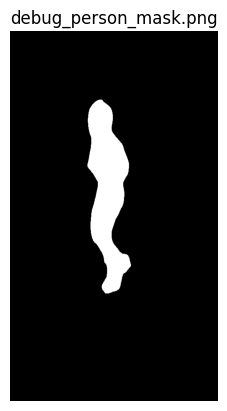

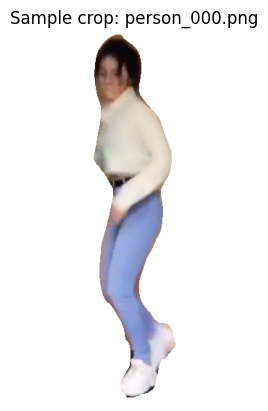

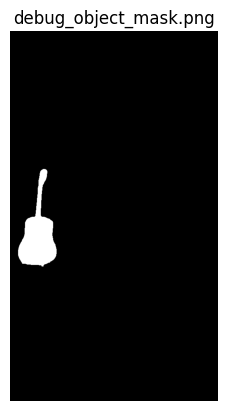

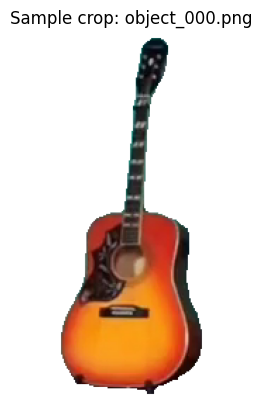

In [19]:
# Quick sanity previews ---
import glob
from matplotlib import pyplot as plt

for class_name in targets.keys():
    dbg = f"/content/debug_{class_name}_mask.png"
    if os.path.exists(dbg):
        m = cv2.imread(dbg, cv2.IMREAD_GRAYSCALE)
        plt.figure()
        plt.title(f"debug_{class_name}_mask.png")
        plt.imshow(m, cmap="gray")
        plt.axis("off")

    files = sorted(glob.glob(os.path.join(OUTPUT_ROOT, class_name, f"{class_name}_*.png")))
    if files:
        img = cv2.imread(files[0], cv2.IMREAD_UNCHANGED)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
        plt.figure()
        plt.title(f"Sample crop: {os.path.basename(files[0])}")
        plt.imshow(img_rgb)
        plt.axis("off")

plt.show()
